Three approaches:

**1. Data Analytics Approach**

- Pros: Simple to implement, very efficient
- Cons: More difficult to make use of many variables which may be necessary to be accurate

**2. Machine learning (with variations in features used and models)**

- Pros: Efficient, can make use of all features, finds linear and nonlinear contributions from features,
- Cons: May require lots of data, may overfit if you are not careful, may not generalize to new domains

**3. Bottom-up Data Analytics Approach**
- Pros: No labels required! 
- Cons: Very computationally expensive without further improvements (n!), same issues with data analytics approach with using extra features, still need test set to validate assumptions

In [1]:
# TODO
# - Create pure inference functions
# - Add more features to everything
# - ML section with varying models
# - Clean up code and comment, add more plots
# - Create presentation inside jupyter
# - LSTM to compare/predict title/description

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import hmean
from nltk.corpus import stopwords
import string
import os
import joblib
import numpy as np

from IPython.display import display

%matplotlib inline

In [3]:
airbnb_property_info = pd.read_csv("property_matching_takehome/airbnb_property_info.csv")
airbnb_property_info["description"].fillna("",inplace=True)
homeaway_property_info = pd.read_csv("property_matching_takehome/homeaway_property_info.csv")
labels = pd.read_csv("property_matching_takehome/labels.csv")
print("Airbnb size: {}, Homeaway size: {}, Labels size: {}".format(len(airbnb_property_info),len(homeaway_property_info), len(labels)))

airbnb_property_info = airbnb_property_info[["airbnb_property_id", "latitude","longitude","title","description"]]
homeaway_property_info = homeaway_property_info[["homeaway_property_id", "latitude","longitude","title","description"]]


labels = labels.merge(airbnb_property_info, on="airbnb_property_id")
labels = labels.merge(homeaway_property_info, on="homeaway_property_id")

labels

Airbnb size: 1995, Homeaway size: 1971, Labels size: 2038


,airbnb_property_id,homeaway_property_id,target,latitude_x,longitude_x,title_x,description_x,latitude_y,longitude_y,title_y,description_y
0,129351,8812517,0.0,39.676288,-0.206689,Canet beach penthouse,An Attic with terrace of 55 m2 with beautiful ...,39.677346,-0.205110,Canet Beach Apartment,Pets allowed Recommended capacity 4 people. Id...
1,4607554,8765586,0.0,51.513959,-0.142421,Luxury 2 Bedroom Apartment in Mayfair,This luxury apartment is spectacularly located...,51.506852,-0.148981,2 Bedroom Serviced Apartment in Mayfair,20 Hertoford Street - Deluxe Two bedroom Serv...
2,10172216,528785,0.0,25.785296,-80.142507,"Great apartment in the heart of South Beach, M...","Cozy apartment in the heart of South Beach, ju...",25.779122,-80.137625,Art Deco Apartment in the heart of South Beach,850 Jefferson is an Art Deco apartment buildin...
3,10727414,805008vb,1.0,47.584139,1.322802,Gite Blois Gare avec Trampoline Géant,Quiet haven where you can relax. A 15 minute w...,47.584829,1.321621,*** 4Br w/Huge Trampoline! Loire Valley Chatea...,"Our house is located in Blois, a quiet haven w..."
4,15032544,8525334,0.0,45.900327,6.125075,Cosy flat in the center of Annecy,"Hi, \n\nI rent my entirely renewed flat locate...",45.903968,6.118825,Cozy nest in the center of Annecy,"Close to the city center, this cozy apartment ..."
5,15882699,1655038,1.0,41.918841,3.207872,GALA 1-apartment with sea views-Tamariu-Costa ...,Gala Apartments are located in a building loc...,41.917988,3.206712,GALA 1-apartment with sea views-Tamariu-Costa ...,Gala Apartments are located in a building loc...
6,16001588,8104315,1.0,45.492112,9.223575,New-Appartamento accogliente in zona ben servita,"Appartamento vicino a P.le Loreto, Staz. Centr...",45.491603,9.223782,New apartment in a well served area - New flat...,"Apartment near Piazzale Loreto, Central Statio..."
7,11565818,4132725,0.0,-34.589909,-58.422844,Palermo Soho Sunny Terrace,A nice apartment for up to 3 people with a spl...,-34.590139,-58.424107,PALERMO SOHO STUDIO6 2/3 PAX NEW,\n This apartment is brand ne...
8,19898608,8547631,1.0,38.717587,-9.135959,TravelingToLisbon 316 - Martim Moniz,"2 bedroom apartment, very near the Martim Moni...",38.716947,-9.135031,Apartment in Lisbon 316 - Martim Moniz,"Apartment 316 is located in Martim Moniz, just..."
9,19856679,8730481,0.0,46.159514,-1.145314,Attic*** downtown beautiful volume authenticity,"Formerly guest house, La Petite Roche, we have...",46.158481,-1.144821,Cozy T2 downtown - old harbor with terrace,Benefits of high quality for this T1 bis 30m2 ...


In [4]:
airbnb_property_info.describe()

,airbnb_property_id,latitude,longitude
count,1.995000e+03,1995.000000,1995.000000
mean,1.853124e+07,33.139277,-23.525509
std,7.493297e+06,18.538609,63.662478
min,2.591000e+04,-45.883722,-159.512886
25%,1.418847e+07,28.425067,-81.451179
50%,2.030527e+07,38.041118,-0.669055
75%,2.407106e+07,43.536873,12.343246
max,3.024615e+07,64.141753,176.241264


,Max Overmatched,Num AirBnB Undrematched,Num Homeaway Undermatched,Significant Digit
0,1970,0,0,-3
1,921,0,0,-2
2,291,0,0,-1
3,145,2,0,0
4,144,9,0,1
5,113,21,0,2
6,13,24,0,3
7,1,24,0,4
8,0,24,0,5


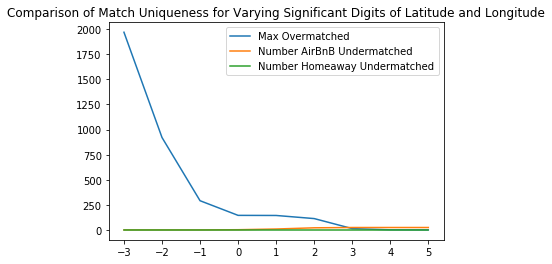

In [5]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

def learn_bow_transformer(airbnb_property_info, homeaway_property_info):
    if os.path.isfile("models/bow_description_vectorizer.pkl"):
        print("Learning bag of words vectorizer")
        bow_transformer = joblib.load("models/bow_description_vectorizer.pkl")
        
    else:
#         bow_transformer = CountVectorizer(analyzer=text_process)
        bow_transformer = CountVectorizer(analyzer=text_process)
        bow_transformer.fit(airbnb_property_info['description'].dropna())
        bow_transformer.fit(homeaway_property_info['description'].dropna())
        
        joblib.dump(bow_transformer, "models/bow_description_vectorizer.pkl")
    
    return bow_transformer

def convert_count_vectorizer2vector(x):
    
    vector = [s.split("\t")[-1] for s in x.split("\n")]
    
    return vector

def combine_data_naive(significant_digits, vectorize_words=False):
    airbnb_property_info = pd.read_csv("property_matching_takehome/airbnb_property_info.csv")
    homeaway_property_info = pd.read_csv("property_matching_takehome/homeaway_property_info.csv")
    
    airbnb_property_info = airbnb_property_info[["airbnb_property_id", "latitude","longitude","title","description"]]
    homeaway_property_info = homeaway_property_info[["homeaway_property_id", "latitude","longitude","title","description"]]
    
    if vectorize_words:
        bow_transformer = learn_bow_transformer(airbnb_property_info, homeaway_property_info)
        print("Now applying bow vectorizer to extract vectors...")
        
        airbnb_property_info["description"].fillna("",inplace=True)
        homeaway_property_info["description"].fillna("",inplace=True)
        
        airbnb_property_info["description_vector"] = airbnb_property_info["description"].apply(lambda x: bow_transformer.transform([x]))
        homeaway_property_info["description_vector"] = homeaway_property_info["description"].apply(lambda x: bow_transformer.transform([x]))
#         airbnb_property_info["description_vector"] = bow_transformer.transform(airbnb_property_info["description"])
#         airbnb_property_info["description_vector"] = airbnb_property_info["description_vector"].apply(convert_count_vectorizer2vector)
#         homeaway_property_info["description_vector"] = bow_transformer.transform(homeaway_property_info["description"])
#         homeaway_property_info["description_vector"] = homeaway_property_info["description_vector"].apply(convert_count_vectorizer2vector)
        
        print("Finished applying vectors, now merging...")
        
    airbnb_property_info["latitude_x"] = airbnb_property_info["latitude"]
    airbnb_property_info["longitude_x"] = airbnb_property_info["longitude"]
    homeaway_property_info["latitude_y"] = homeaway_property_info["latitude"]
    homeaway_property_info["longitude_y"] = homeaway_property_info["longitude"]
    
    airbnb_property_info["latitude"] = airbnb_property_info["latitude"].apply(lambda x: round(x, significant_digits))
    airbnb_property_info["longitude"] = airbnb_property_info["longitude"].apply(lambda x: round(x, significant_digits))
    homeaway_property_info["latitude"] = airbnb_property_info["latitude"].apply(lambda x: round(x, significant_digits))
    homeaway_property_info["longitude"] = airbnb_property_info["longitude"].apply(lambda x: round(x, significant_digits))

    combined = airbnb_property_info.merge(homeaway_property_info,how="left",on=["latitude","longitude"])
    
    return combined

min_significant_digits = -3
max_significant_digits = 6
overmatched_list = []
left_undermatched_list = []
right_undermatched_list = []

for i in range(min_significant_digits, max_significant_digits):
    significant_digits = i

    combined = combine_data_naive(significant_digits)
    
    number_overmatched = combined["airbnb_property_id"].value_counts().max() - 1
    number_undermatched_left = len(combined[combined["homeaway_property_id"].isnull()])
    number_undermatched_right = homeaway_property_info["homeaway_property_id"].nunique() - combined["homeaway_property_id"].nunique()

    overmatched_list.append(number_overmatched)
    left_undermatched_list.append(number_undermatched_left)
    right_undermatched_list.append(number_undermatched_right)
                                                                                                    

x = [i for i in range(min_significant_digits,max_significant_digits)]

json = {}
json["Significant Digit"] = x
json["Max Overmatched"] = overmatched_list
json["Num AirBnB Undrematched"] = left_undermatched_list
json["Num Homeaway Undermatched"] = right_undermatched_list

table = pd.DataFrame.from_dict(json)
display(table)

plt.plot(x, overmatched_list, label="Max Overmatched")
plt.plot(x, left_undermatched_list, label="Number AirBnB Undermatched")
plt.plot(x, right_undermatched_list, label="Number Homeaway Undermatched")
plt.title("Comparison of Match Uniqueness for Varying Significant Digits of Latitude and Longitude")
plt.legend()
plt.show()

#Conclusion: significant digits = -1 but need to filter

In [6]:
bow_transformer = learn_bow_transformer(airbnb_property_info, homeaway_property_info)
print("Now applying bow vectorizer to extract vectors...")

labels["description_x"].fillna("",inplace=True)
labels["description_y"].fillna("",inplace=True)

# labels["description_vector_x"] = labels["description_x"].apply(lambda x: bow_transformer.transform([x]))
# labels["description_vector_y"] = labels["description_y"].apply(lambda x: bow_transformer.transform([x]))
labels["description_vector_x"] = labels["title_x"].apply(lambda x: bow_transformer.transform([x]))
labels["description_vector_y"] = labels["title_y"].apply(lambda x: bow_transformer.transform([x]))


Learning bag of words vectorizer
Now applying bow vectorizer to extract vectors...


(array([516., 122., 150., 135., 185., 126.,  84.,  83.,  50., 587.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

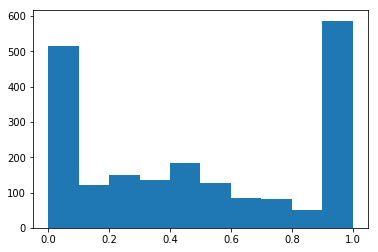

In [7]:
labels_enhanced = labels.copy()
labels_enhanced["cosine_similarity"] = labels.apply(lambda row: cosine_similarity(row["description_vector_x"], row["description_vector_y"])[0], axis=1)['description_vector_x']


columns_to_delete = []

labels_enhanced
plt.hist(labels_enhanced["cosine_similarity"])

(array([1.618e+03, 3.300e+02, 7.400e+01, 9.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.04534955,  0.52158771,  2.08852497,  3.65546224,  5.2223995 ,
         6.78933676,  8.35627403,  9.92321129, 11.49014855, 13.05708582,
        14.62402308]),
 <a list of 10 Patch objects>)

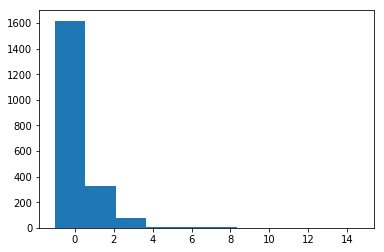

In [8]:
def euclidean_distance(row):# Euclidean distance is a decent approximation for short distances. No need to use Haversine.
    x1 = row["latitude_x"]
    y1 = row["longitude_x"]
    x2 = row["latitude_y"]
    y2 = row["longitude_y"]
    return ((x2-x1) ** 2 + (y2-y1) ** 2) ** (1/2)

# Could use z-score instead but this would not be conveniently between 0 and 1
def normalize_euclidean(distance, mean, std):
#     normalized = (distance - min_distance) / (max_distance - min_distance)
    normalized = (distance - mean) / std
    return normalized
    
labels_enhanced["euclidean_distance"] = labels_enhanced.apply(lambda row: euclidean_distance(row), axis=1)
min_distance = labels_enhanced["euclidean_distance"].min()
max_distance = labels_enhanced["euclidean_distance"].max()

distance_mean = labels_enhanced["euclidean_distance"].mean()
distance_std = labels_enhanced["euclidean_distance"].std()

labels_enhanced["normalized_euclidean_distance"] = labels_enhanced.apply(lambda row: normalize_euclidean(row["euclidean_distance"],distance_mean,distance_std), axis=1)
plt.hist(labels_enhanced["normalized_euclidean_distance"])


In [9]:
# Split to "training" and "test" set

NUM_IN_TRAIN = 1500

labels_enhanced = labels_enhanced.sample(frac=1).reset_index(drop=True)
labels_enhanced_train = labels_enhanced[:1500]
labels_enhanced_test = labels_enhanced[1500:]

In [10]:
def infer(euclidean_distance, cosine_similarity, distance_threshold, similarity_threshold):
    if euclidean_distance < distance_threshold and cosine_similarity > similarity_threshold:
        return 1
    else:
        return 0
    
def make_prediction_and_evaluate(train_data, distance_threshold, similarity_threshold, verbose=False):
    data["prediction"] = data.apply(lambda row: infer(row["normalized_euclidean_distance"], row["cosine_similarity"], distance_threshold, similarity_threshold), axis=1)

    confusion = train_data.groupby("target")["prediction"].value_counts()
    
    if 1 in confusion[1]:
        tp = confusion[1][1]
    else:
        return 0, 0, 0
    
    if 0 in confusion[0]:
        tn = confusion[0][0]
    else:
        tn = 0
    
    if 0 in confusion[1]:
        fn = confusion[1][0]
    else:
        fn = 0
        
    if 1 in confusion[0]:
        fp = confusion[0][1]
    else:
        fp = 0

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = hmean([precision, recall])

    if verbose:
        print("Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(precision, recall, f1))
    
    return precision, recall, f1

def grid_search(train_data, grid_size=20, max_distance=2, min_similarity=.25):
    best_hyperparameters = {}
    best_hyperparameters["best_precision"] = {}
    best_hyperparameters["best_precision"]["precision"] = 0
    best_hyperparameters["best_recall"] = {}
    best_hyperparameters["best_recall"]["recall"] = 0
    best_hyperparameters["best_f1"] = {}
    best_hyperparameters["best_f1"]["f1"] = 0
    
    for similarity_threshold in np.linspace(min_similarity, 1, grid_size):
        for distance_threshold in np.linspace(train_data["normalized_euclidean_distance"].min(), max_distance, grid_size):
            precision, recall, f1 = make_prediction_and_evaluate(train_data, distance_threshold, similarity_threshold)
            
            if precision > best_hyperparameters["best_precision"]["precision"]:
                best_hyperparameters["best_precision"]["precision"] = precision
                best_hyperparameters["best_precision"]["similarity_threshold"] = similarity_threshold
                best_hyperparameters["best_precision"]["distance_threshold"] = distance_threshold
                
            if recall > best_hyperparameters["best_recall"]["recall"]:
                best_hyperparameters["best_recall"]["recall"] = recall
                best_hyperparameters["best_recall"]["similarity_threshold"] = similarity_threshold
                best_hyperparameters["best_recall"]["distance_threshold"] = distance_threshold
                
            if f1 > best_hyperparameters["best_f1"]["f1"]:
#                 print(f1, similarity_threshold, distance_threshold)
                best_hyperparameters["best_f1"]["f1"] = f1
                best_hyperparameters["best_f1"]["similarity_threshold"] = similarity_threshold
                best_hyperparameters["best_f1"]["distance_threshold"] = distance_threshold
                
    best_similarity_threshold = best_hyperparameters["best_f1"]["similarity_threshold"]
    best_distance_threshold = best_hyperparameters["best_f1"]["distance_threshold"]
    best_f1_achieved = best_hyperparameters["best_f1"]["f1"]
    
    print("Best F1 Achieved: {:.3f}, Best distance_threshold: {:.3f}, Best similarity_threshold: {:.3f}".format(best_f1_achieved, best_distance_threshold, best_similarity_threshold))
    return best_hyperparameters

best_hyperperameters = grid_search(labels_enhanced_train, grid_size=10, max_distance=2, min_similarity=0)

NameError: name 'data' is not defined

In [ ]:
best_hyperperameters["best_precision"]

In [ ]:

labels_enhanced_train["prediction"] = labels_enhanced_train.apply(lambda row: infer(row["normalized_euclidean_distance"], row["cosine_similarity"], 1.6, .44), axis=1)

confusion = labels_enhanced_train.groupby("target")["prediction"].value_counts()

if 1 in confusion[1]:
    tp = confusion[1][1]
else:
    tp = 0

if 0 in confusion[0]:
    tn = confusion[0][0]
else:
    tn = 0

if 0 in confusion[1]:
    fn = confusion[1][0]
else:
    fn = 0

if 1 in confusion[0]:
    fp = confusion[0][1]
else:
    fp = 0

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = hmean([precision, recall])


print("Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(precision, recall, f1))

labels_enhanced_train["incorrect"] = labels_enhanced_train.apply(lambda row: 1 if row["target"] != row["prediction"] else , axis=1)

In [ ]:
# Machine learning approach



# Bottom-Up Data Analytics Approach

In [ ]:
naive_match = combine_data_naive(-1, vectorize_words=True)
print("Number of rough matches: ", len(naive_match))
rough_matches_counts = naive_match["airbnb_property_id"].value_counts()
overmatch_ids = rough_matches_counts[rough_matches_counts > 1]
print("Number of ids that overmatched: ", len(overmatch_ids))
naive_match["title_y"].fillna("", inplace=True)
naive_match["description_y"].fillna("", inplace=True)
naive_match.head()

In [ ]:
# Apply cosine similarity
print(len(naive_match))
naive_match.reset_index(drop=True, inplace=True)
naive_match["cosine_similarity"] = naive_match.apply(lambda row: cosine_similarity(row["description_vector_x"], row["description_vector_y"])[0], axis=1)["description_vector_x"]


In [ ]:
def euclidean_distance(row):
    x1 = row["latitude_x"]
    y1 = row["longitude_x"]
    x2 = row["latitude_y"]
    y2 = row["longitude_y"]
    return ((x2-x1) ** 2 + (y2-y1) ** 2) ** (1/2)

# Could use z-score instead but this would not be conveniently between 0 and 1
def normalize_euclidean(distance, mean, std):
#     normalized = (distance - min_distance) / (max_distance - min_distance)
    normalized = (distance - mean) / std
    return normalized

naive_match["euclidean_distance"] = naive_match.apply(lambda row: euclidean_distance(row), axis=1)
min_distance = naive_match["euclidean_distance"].min()
max_distance = naive_match["euclidean_distance"].max()

distance_mean = naive_match["euclidean_distance"].mean()
distance_std = naive_match["euclidean_distance"].std()

naive_match["normalized_euclidean_distance"] = naive_match.apply(lambda row: normalize_euclidean(row["euclidean_distance"],distance_mean,distance_std), axis=1)
plt.hist(naive_match["normalized_euclidean_distance"])

In [ ]:
 naive_match["prediction"] = naive_match.apply(lambda row: infer(row["normalized_euclidean_distance"], row["cosine_similarity"], 2, .4), axis=1)

In [ ]:
filtered_match = naive_match[naive_match["prediction"] == 1]
print("Filtered length match: ", len(filtered_match))
filtered_match["airbnb_property_id"].value_counts().max() - 1
print("Number of unique homeaway property ids: ", filtered_match["homeaway_property_id"].nunique())

In [ ]:
# bow_transformer = joblib.load("models/bow_description_vectorizer.pkl")
bow_transformer.fit(airbnb_property_info['description'].dropna())


In [ ]:
vector1 = bow_transformer.transform([homeaway_property_info["description"][0]])
print(vector1)
vector2 = bow_transformer.transform([homeaway_property_info["description"][1]])

In [ ]:
for i in np.linspace(0,1,11):
    print(i)